In [277]:
import pandas as pd

# Getting data from the original form into anything functional

transform from all divisions and years into 1 dataframe for each country

In [278]:
import os
import pandas as pd

root_dir = "data"
folder_dfs = {}  # Nested dict: country -> subfolder -> CSV -> DataFrame

# Walk through all directories
for dirpath, dirnames, filenames in os.walk(root_dir):
    if dirpath == root_dir:
        continue  # skip root

    # Split the path components relative to data/
    rel_path = os.path.relpath(dirpath, root_dir).split(os.sep)

    # Expecting: ["england", "0"] or ["england", "1"], etc.
    if len(rel_path) != 2:
        continue  # skip if not exactly two levels below root

    country, subfolder = rel_path

    # Initialize nested dicts
    folder_dfs.setdefault(country, {})
    folder_dfs[country].setdefault(subfolder, {})

    # Loop through CSV files
    for filename in filenames:
        if filename.endswith(".csv"):
            file_path = os.path.join(dirpath, filename)
            df = pd.read_csv(file_path)

            csv_name = os.path.splitext(filename)[0]  # e.g. "1920"
            folder_dfs[country][subfolder][csv_name] = df

# Check the structure
for country, subfolders in folder_dfs.items():
    print(f"\nCountry: {country}")
    for sub, csvs in subfolders.items():
        print(f"Subfolder: {sub}")
        for name, df in csvs.items():
            print(f"    - {name}.csv → shape={df.shape}")


def concat_country_data(country_name):
    """Concatenate all CSVs for a given country (across all subfolders)."""
    # Flatten all subfolder DataFrames into one list
    dfs = []
    for subfolder in folder_dfs[country_name].values():
        dfs.extend(subfolder.values())
    # Combine them into one big DataFrame
    return pd.concat(dfs, ignore_index=True)

# Build DataFrames per country
belgium_data     = concat_country_data("belgium")
england_data     = concat_country_data("england")
france_data      = concat_country_data("france")
germany_data     = concat_country_data("germany")
greece_data      = concat_country_data("greece")
italy_data       = concat_country_data("italy")
netherlands_data = concat_country_data("netherlands")
portugal_data    = concat_country_data("portugal")
scotland_data    = concat_country_data("scotland")
spain_data       = concat_country_data("spain")
turkey_data      = concat_country_data("turkey")



FILEPATH=""
country_dfs = {
    "belgium": belgium_data,
    "england": england_data,
    "france": france_data,
    "germany": germany_data,
    "greece": greece_data,
    "italy": italy_data,
    "netherlands": netherlands_data,
    "portugal": portugal_data,
    "scotland": scotland_data,
    "spain": spain_data,
    "turkey": turkey_data
}


output_dir = "combined_csvs"  # folder to save all CSVs
os.makedirs(output_dir, exist_ok=True)  # create folder if it doesn't exist

for country, df in country_dfs.items():
    # Safe file path
    file_path = os.path.join(output_dir, f"{country}.csv")
    
    df.to_csv(file_path, index=False)
    print(f" Saved {file_path} (shape={df.shape})")


Country: belgium
Subfolder: 1
    - 1920.csv → shape=(232, 105)
    - 2021.csv → shape=(306, 105)
    - 2122.csv → shape=(306, 106)
    - 2223.csv → shape=(306, 105)
    - 2324.csv → shape=(312, 105)
    - 2425.csv → shape=(312, 121)

Country: england
Subfolder: 0
    - 1920.csv → shape=(380, 106)
    - 2021.csv → shape=(380, 106)
    - 2122.csv → shape=(380, 106)
    - 2223.csv → shape=(380, 106)
    - 2324.csv → shape=(380, 106)
    - 2425.csv → shape=(380, 120)
Subfolder: 1
    - 1920.csv → shape=(552, 106)
    - 2021.csv → shape=(552, 106)
    - 2122.csv → shape=(552, 106)
    - 2223.csv → shape=(552, 106)
    - 2324.csv → shape=(552, 106)
    - 2425.csv → shape=(552, 120)
Subfolder: 2
    - 1920.csv → shape=(400, 106)
    - 2021.csv → shape=(552, 106)
    - 2122.csv → shape=(552, 106)
    - 2223.csv → shape=(552, 106)
    - 2324.csv → shape=(552, 106)
    - 2425.csv → shape=(552, 120)
Subfolder: 3
    - 1920.csv → shape=(440, 106)
    - 2021.csv → shape=(552, 106)
    - 2122.csv 

# Transformation and feature engineering

this section is where the magic happens. We create one datasets for A0 and A1 models from original imput

In [279]:
#this import a bit useless since data is already here, but in case of separation its good 
#import of data
b_data=pd.read_csv(r'combined_csvs\belgium.csv')
eng_data = pd.read_csv(r'combined_csvs\england.csv')
fr_data=pd.read_csv(r'combined_csvs\france.csv')
d_data=pd.read_csv(r'combined_csvs\germany.csv')
gr_data=pd.read_csv(r'combined_csvs\greece.csv')
it_data=pd.read_csv(r'combined_csvs\italy.csv')
ne_data=pd.read_csv(r'combined_csvs\netherlands.csv')
por_data=pd.read_csv(r'combined_csvs\portugal.csv')
sc_data=pd.read_csv(r'combined_csvs\scotland.csv')
sp_data=pd.read_csv(r'combined_csvs\spain.csv')
tur_data=pd.read_csv(r'combined_csvs\turkey.csv')


C:\Users\vojte\AppData\Local\Temp\ipykernel_3816\1879345392.py:11: DtypeWarning: Columns (70) have mixed types. Specify dtype option on import or set low_memory=False.
  sc_data=pd.read_csv(r'combined_csvs\scotland.csv')


# creation of A0 dataset

original data is limited in what we can do with it but at first we need to get it into the A0 form.

Firstly we get country and division from 'Div' variable, then we need to create out target variable for set task. Last thing done in the code block is transforming time into reliable format for further work

In [280]:
col_list_a0=['Div','Date','Time','HomeTeam','AwayTeam','FTHG','FTAG','FTR']
def a0_data(df,feature_list):
    df=df[feature_list]
    df[['Country', 'Division']] =df['Div'].str.extract(r'([A-Za-z]+)(\d+)')
    df.drop(columns=['Div'], inplace=True)
    df['Total_goals']=df['FTHG']+df['FTAG']
    df['Target']= (df['Total_goals']>2.5).astype(int) #1 if more than 2 goals were scored, else 0
    df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
    df['Time'] = pd.to_datetime(df['Time'], format='%H:%M').dt.hour
    return df

data_og=pd.DataFrame()

for df in [belgium_data, eng_data, fr_data, d_data, gr_data, it_data, ne_data, por_data, sc_data, sp_data, tur_data]:
    data_og=pd.concat([data_og,df], ignore_index=True)






In [281]:
b_data_a0.head()

,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,Country,Division,Total_goals,Target
0,2019-07-26,19,Genk,Kortrijk,2,1,H,B,1,3,1
1,2019-07-27,17,Cercle Brugge,Standard,0,2,A,B,1,2,0
2,2019-07-27,19,St Truiden,Mouscron,0,1,A,B,1,1,0
3,2019-07-27,19,Waregem,Mechelen,0,2,A,B,1,2,0
4,2019-07-27,19,Waasland-Beveren,Club Brugge,1,3,A,B,1,4,1


Secondly, we try to get the most out of A0 data. This includes:

-Spliting date into 3 variables and getting season of the year(winter,spring,summer,autumn).

-Then we use LabelEncoder for encoding of the teams, we use same encoder for teams to have same number in both home and away column.

-Then we derive variables for home and away teams, variables chosen are Average of goals scored, and Average of goals conceded - both in last 5 matches. This creates systematically couple of missing values in the data(specifically 10 per unique team in dataset), but due to character of the data, the first 10 matches have minimal influence on later matches(excluding psychological, but thats hard to measure).

-Countries and divisions are encoded into dummies, due to character of the data this doesnt really clog the model with too many variables.

-Tail of the function drops columns used in calculations of derived variables, so we avoid collinearity.

Note:keeping home and away games for each team seperate is supported by this: here[https://www.mdpi.com/2076-3417/15/4/2242]

In [282]:
'''
Planned features for A0 dataset:
original dataset: 
Div (later split into)
    Country
    Division
Date (later split into)
    Year
    Month
    Dayofweek
    isweekend
    Season of year (spring, summer, autumn, winter) - 4 categories encoded 0=winter,1=spring,etc.
Time -range is (0-24)
HomeTeam- encoded
AwayTeam- encoded same as HomeTeam
FTHG- get averages, then drop    expected   range(0-6)
FTAG- get averages, then drop    expected   range(0-6)
FTR- drop (full time result) not needed IDK BOUT THIS ONE GUYS
Reasoning for differing variables for goals home and away for every team is supported a study linked here{https://www.mdpi.com/2076-3417/15/4/2242}
'''
from sklearn.preprocessing import LabelEncoder

def get_season(date):
      month = date.month
      if month in [12, 1, 2]:
          return 0
      elif month in [3, 4, 5]:
          return 1
      elif month in [6, 7, 8]:
          return 2
      else:
          return 3
    


def transf_encode_a0(df):
    #encodery:
    team_encoder = LabelEncoder()
    df=df.sort_values('Date')# sort to make sure averages are for the 5 previous matches
    mean_goals=df.groupby  
    #"Home" variables:
    df['HomeTeam_enc'] = team_encoder.fit_transform(df['HomeTeam'])
    df = df.sort_values(["HomeTeam_enc", "Date"])
    df['avg_goals_in_last5_home']=(
    df.groupby("HomeTeam_enc")["FTHG"]
      .transform(lambda x: x.shift().rolling(5, min_periods=1).mean()))
    df['avg_goals_conceded_last5_home']=(
    df.groupby("HomeTeam_enc")["FTAG"]
      .transform(lambda x: x.shift().rolling(5, min_periods=1).mean()))
    
    #"Away" variables:
    df['AwayTeam_enc'] = team_encoder.transform(df['AwayTeam'])
    df = df.sort_values(["AwayTeam_enc", "Date"])
    df['avg_goals_in_last5_away']= (
    df.groupby("AwayTeam_enc")["FTAG"]
      .transform(lambda x: x.shift().rolling(5, min_periods=1).mean()))
    df['avg_goals_conceded_last5_away']=(
    df.groupby("AwayTeam_enc")["FTHG"]
      .transform(lambda x: x.shift().rolling(5, min_periods=1).mean()))
    
    df=df.sort_values('Date')# sort back to original order    
    # Basic calendar-based features
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Dayofweek'] = df['Date'].dt.dayofweek  # Monday=0, Sunday=6
    df['Is_weekend'] = df['Dayofweek'].isin([5, 6]).astype(int)
    df['Season_of_year'] = df['Date'].apply(get_season)

    #This is placed here in case we want to use it for seperate countries or in general
    if 'Country' in df.columns:
        df=pd.get_dummies(df, columns=['Country','Division'],drop_first=True)
        #encode country/dummies
    else:
        df=pd.get_dummies(df, columns=['Division'],drop_first=True)
        df=df.drop(columns=['Country'])


    #dropping columns we dont need, that would mess with the model
    df=df.drop(columns=['Total_goals','FTHG','FTAG','FTR','HomeTeam','AwayTeam','Date'])
    return df
    

b_data_a0= a0_data(b_data,col_list_a0)
eng_data_a0 = a0_data(eng_data,col_list_a0)
fr_data_a0=a0_data(fr_data,col_list_a0)
d_data_a0=a0_data(d_data,col_list_a0)
gr_data_a0=a0_data(gr_data,col_list_a0)
it_data_a0=a0_data(it_data,col_list_a0)
ne_data_a0=a0_data(ne_data,col_list_a0)
por_data_a0=a0_data(por_data,col_list_a0)
sc_data_a0=a0_data(sc_data,col_list_a0)
sp_data_a0=a0_data(sp_data,col_list_a0)
tur_data_a0=a0_data(tur_data,col_list_a0)
data_og_a0=a0_data(data_og,col_list_a0)


b_data_a0_encoded=transf_encode_a0(b_data_a0)
eng_data_a0_encoded=transf_encode_a0(eng_data_a0)
fr_data_a0_encoded=transf_encode_a0(fr_data_a0)
d_data_a0_encoded=transf_encode_a0(d_data_a0)
gr_data_a0_encoded=transf_encode_a0(gr_data_a0)
it_data_a0_encoded=transf_encode_a0(it_data_a0)
ne_data_a0_encoded=transf_encode_a0(ne_data_a0)
por_data_a0_encoded=transf_encode_a0(por_data_a0)
sc_data_a0_encoded=transf_encode_a0(sc_data_a0)
sp_data_a0_encoded=transf_encode_a0(sp_data_a0)
tur_data_a0_encoded=transf_encode_a0(tur_data_a0)
data_og_a0_encoded=transf_encode_a0(data_og_a0)


C:\Users\vojte\AppData\Local\Temp\ipykernel_3816\3852308383.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['Country', 'Division']] =df['Div'].str.extract(r'([A-Za-z]+)(\d+)')
C:\Users\vojte\AppData\Local\Temp\ipykernel_3816\3852308383.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['Country', 'Division']] =df['Div'].str.extract(r'([A-Za-z]+)(\d+)')
C:\Users\vojte\AppData\Local\Temp\ipykernel_3816\3852308383.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

# creation of A1 dataset

Bigger dataset is strained with an opposite problem  in comparison to orignal data. It is messy, the notes.txt file dont contain the nature of the data. With complete honesty I would find a different vendor for the data as the business i am to enact. While there is more it is hard to use anything else than the market aggregates. In the notes in the code is again written out the general idea behind the code and which variables i chose to use and transform in feature engineering.

In [283]:
'''Planned features for A1 dataset:
original dataset: 
Div (later split into)
    Country
    Division
Date (later split into)
    Year
    Month
    Dayofweek
    isweekend
    Season of year (spring, summer, autumn, winter) - 4 categories encoded 0=winter,1=spring,etc.
Time -range is (0-24)
HomeTeam- encoded
AwayTeam- encoded same as HomeTeam
FTHG- get averages, then drop    expected   range(0-6)
FTAG- get averages, then drop    expected   range(0-6)
FTR- drop (full time result) not needed IDK BOUT THIS ONE GUYS
-------------------------------------------
Bigger dataset:
Market AsianHandicap variables:
    MaxAHH = Market maximum Asian handicap home team odds
    MaxAHA = Market maximum Asian handicap away team odds	
    AvgAHH = Market average Asian handicap home team odds
    AvgAHA = Market average Asian handicap away team odds
Note: Have to use market average, due to missingness of variables
-------------------------------------------
target variable necessarry:
Total_goals - sum of FTHG and FTAG  range(0-12)
Target - (Total_goals>2.5)  0 or 1
-------------------------------------------
---IGNORE---
WOULD be used for shot conversion:

    HST = Home Team Shots on Target
    AST = Away Team Shots on Target
    HHW = Home Team Hit Woodwork
    AHW = Away Team Hit Woodwork
    formula for coversion rate =goals scored/(shot on target+hit woodwork)... in last 5 games
    formula for xG= conversion rate * (shot on target+hit woodwork)... in last 5 games 
'''

col_list_a1=['Div','Date','Time','HomeTeam','AwayTeam','FTHG','FTAG','FTR','AvgAHH','AvgAHA',
             'Avg>2.5','Avg<2.5',]

def a1_data(df,feature_list):
    
    df=df[feature_list]
    df[['Country', 'Division']] =df['Div'].str.extract(r'([A-Za-z]+)(\d+)')
    df.drop(columns=['Div'], inplace=True)
    df['Total_goals']=df['FTHG']+df['FTAG']
    df['Target']= (df['Total_goals']>2.5).astype(int) #1 if more than 2 goals were scored, else 0
    return df



Same process with the overlapping variables from A0. But in the rest we did the following:

.We keep previous metrics, because they are performance focused

.What is extra is that we get market sentiment data like Over/under odds which may be highly correlated with the performance metrics, but are different look at the data. This is meant to generate profit of the betting market. O/U easily explained as a bet if the match i going to have more or less than 2 goals scored in standart playtime.

.This also applies to the Asian Handicap.This term could be easily explained as the imbalance in force of the competing teams. Both of the betting odds are transformed into probabilities which is more easily translated into machine learning environment.

.Lasty, we again drop big decent number of derived variables are temporary, thus deleted from the final dataset.

.!Disclaimer!
Enhanced performance metrics i tried to code were impossible to do, there are not the full data provided as promised. Data provider has a documentation for greater size than delivered.

In [284]:


def transf_encode_a1(df):
    #encodery:
    team_encoder = LabelEncoder()
    df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
    df['Time'] = pd.to_datetime(df['Time'], format='%H:%M').dt.hour
    #mean goals calc:
    df=df.sort_values('Date')# sort to make sure averages are for the 5 previous matches
    mean_goals=df.groupby  
    # 'HomeTeam','AwayTeam' same encoding to keep the team numbers same for easiness

 

    #home
    df['HomeTeam_enc'] = team_encoder.fit_transform(df['HomeTeam'])
    df = df.sort_values(["HomeTeam_enc", "Date"])
    '''
    xG calculation - basic data based
    '''
    #Note: removed due to better metric put in place
    #xG_proxy should be more sensible than just avg goals,while correlation is high wi xG proxy
    df['avg_goals_in_last5_home']=(
    df.groupby("HomeTeam_enc")["FTHG"]
      .transform(lambda x: x.shift().rolling(5, min_periods=1).mean()))
    
    df['avg_goals_conceded_last5_home']=(
    df.groupby("HomeTeam_enc")["FTAG"]
      .transform(lambda x: x.shift().rolling(5, min_periods=1).mean()))
    
    #away
    df['AwayTeam_enc'] = team_encoder.transform(df['AwayTeam'])
    #xG calculation - basic data based
    #Note: removed due to better metric put in place
    df['avg_goals_in_last5_away']= (
    df.groupby("AwayTeam_enc")["FTAG"]
      .transform(lambda x: x.shift().rolling(5, min_periods=1).mean()))
    
    df['avg_goals_conceded_last5_away']=(
    df.groupby("AwayTeam_enc")["FTHG"]
      .transform(lambda x: x.shift().rolling(5, min_periods=1).mean()))
    
    df=df.sort_values('Date')# sort back to original order
    
    
    #over/under metrics:
    df["p_over_raw"] = 1 / df["Avg>2.5"]
    df["p_under_raw"] = 1 / df["Avg<2.5"]
    #Normalize to remove overround (so probs sum to 1)
    df["p_over_norm"] = df["p_over_raw"] / (df["p_over_raw"] + df["p_under_raw"])
    df["p_under_norm"] = 1 - df["p_over_norm"]

    #Key modeling features
    df["P_over"] = df["p_over_norm"]
    #df["market_depth"] = df["BbOU"]

    # Raw Over price (for interpretability)
    df["over_price"] = df["Avg>2.5"]
    # how far from a 50/50 market
    df["market_decisiveness"] = (df["P_over"] - 0.5).abs()
    # Simple linear calibration: 2.5 ± 1.5*(P_over - 0.5)
    df["expected_total_goals"] = 2.5 + 1.5 * (df["P_over"] - 0.5)



    #Asian handicap:
    df['Ah_P_home']= 1/df['AvgAHH']  #probability proxy from odds
    df['Ah_P_away']= 1/df['AvgAHA']  #probability proxy from odds
    
    df['Norm_Ah_P_home']= df['Ah_P_home'] / (df['Ah_P_home'] + df['Ah_P_away']) #normalized probability/confidence in the ah imbalance
    df['Norm_Ah_P_away']=1-df['Norm_Ah_P_home']
    '''Interpretation
    Value close to 0.5 → Market sees a balanced match; home and away are roughly equally likely to “cover” the handicap.
    Value > 0.5 → Market favors the home team. Higher value → stronger confidence.
    Value < 0.5 → Market favors the away team.
    '''
    df['ah_imbalance'] = (df['Ah_P_home'] - df['Ah_P_away']).abs() #absolute difference between the market-implied probabilities for the home team and away team in the Asian Handicap market.
    '''Interpretation:
    Close to 0: Market sees the matchup as balanced — probabilities for home and away are nearly equal.
    Large value (toward 1): Market sees a strong imbalance — one team is heavily favored over the other.
    '''
    
    
    df['ah_market_confidence'] = df[['Ah_P_home', 'Ah_P_away']].max(axis=1)
    '''Interpretation:
    Close to 0.5: Market is uncertain — neither team is strongly favored.
    Closer to 1: Market is very confident that one team will win based on the AH odds.
    '''
   
       
    # Basic calendar-based features
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Dayofweek'] = df['Date'].dt.dayofweek  # Monday=0, Sunday=6
    df['Is_weekend'] = df['Dayofweek'].isin([5, 6]).astype(int)
    df['Season_of_year'] = df['Date'].apply(get_season) #0

    #this should make it work for the full file - dummies for country, division should be just fine i guess :eshrug:
    if 'Country' in df.columns:
      #encode country/dummies
      df=pd.get_dummies(df, columns=['Country','Division'],drop_first=True)
    else:
      df=pd.get_dummies(df, columns=['Division'],drop_first=True)
      df=df.drop(columns=['Country'])

 # Drop unneeded columns:
    cols_to_drop = [
    'Total_goals', 'FTHG', 'FTAG', 'FTR', 'HomeTeam', 'AwayTeam', 'Date',
    # Intermediate market vars
    'p_over_raw', 'p_under_raw', 'p_over_norm', 'p_under_norm',
    'over_price', 'P_over',  # keep only expected_total_goals 
    
    # Raw AH odds if not needed
    'Ah_P_home', 'Ah_P_away',
    # Original odds sources (if you don't need them separately)
     'Avg>2.5', 'Avg<2.5', 'AvgAHH', 'AvgAHA'
    ] 
    df=df.drop(columns=cols_to_drop)
    return df
'''
  Note:DATA QUALITY IS AN ISSUE WHEN WE HAVE VARIABLES IN THE NOTES FILE BUT NOT IN ANY OF THE DATASETS 
      --- IGNORE ---
    For some reason the variables promised in the notes file are not in the data :))))))))))))))))))
    #xG calculation - performance based
    df['SCR_home'] = df['HG'] / (df['HST'] + df['HHW'])
    df['xG_proxy_home'] = df['SCR_home'] * (df['HST'] + df['HHW'])
    df['xG_proxy_home_last5']=(
    df.groupby("HomeTeam_enc")["xG_proxy_home"]
      .transform(lambda x: x.shift().rolling(5, min_periods=1). mean()))

    #xG calculation - performance based
    Note:DATA QUALITY IS AN ISSUE WHEN WE HAVE VARIABLES IN THE NOTES FILE BUT NOT IN ANY OF THE DATASETS 
      --- IGNORE ---
    For some reason the variables promised in the notes file are not in the data :))))))))))))))))))
    df['SCR_away'] = df['AG'] / (df['AST'] + df['AHW'])
    df['xG_proxy_away'] = df['SCR_away'] * (df['AST'] + df['AHW'])
    df['xG_proxy_away_last5']=(
    df.groupby("AwayTeam_enc")["xG_proxy_away"]
      .transform(lambda x: x.shift().rolling(5, min_periods=1). mean()))
'''
data_big=pd.DataFrame()

for df in [belgium_data, eng_data, fr_data, d_data, gr_data, it_data, ne_data, por_data, sc_data, sp_data, tur_data]:
    data_big=pd.concat([data_big,df], ignore_index=True)

b_data_a1= a1_data(b_data,col_list_a1)
eng_data_a1 = a1_data(eng_data,col_list_a1)
fr_data_a1=a1_data(fr_data,col_list_a1)
d_data_a1=a1_data(d_data,col_list_a1)
gr_data_a1=a1_data(gr_data,col_list_a1)
it_data_a1=a1_data(it_data,col_list_a1)
ne_data_a1=a1_data(ne_data,col_list_a1)
por_data_a1=a1_data(por_data,col_list_a1)
sc_data_a1=a1_data(sc_data,col_list_a1)
sp_data_a1=a1_data(sp_data,col_list_a1)
tur_data_a1=a1_data(tur_data,col_list_a1)
big_data_a1=a1_data(data_big,col_list_a1)


b_data_a1_encoded= transf_encode_a1(b_data_a1)
eng_a1_encoded = transf_encode_a1(eng_data_a1)
fr_a1_encoded= transf_encode_a1(fr_data_a1)
d_a1_encoded= transf_encode_a1(d_data_a1)
gr_a1_encoded= transf_encode_a1(gr_data_a1)
it_a1_encoded= transf_encode_a1(it_data_a1)
ne_a1_encoded= transf_encode_a1(ne_data_a1)
por_a1_encoded= transf_encode_a1(por_data_a1)
sc_a1_encoded= transf_encode_a1(sc_data_a1)
sp_a1_encoded= transf_encode_a1(sp_data_a1)
tur_a1_encoded= transf_encode_a1(tur_data_a1)
data_big_a1_encoded= transf_encode_a1(big_data_a1)

C:\Users\vojte\AppData\Local\Temp\ipykernel_3816\3816223009.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['Country', 'Division']] =df['Div'].str.extract(r'([A-Za-z]+)(\d+)')
C:\Users\vojte\AppData\Local\Temp\ipykernel_3816\3816223009.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['Country', 'Division']] =df['Div'].str.extract(r'([A-Za-z]+)(\d+)')
C:\Users\vojte\AppData\Local\Temp\ipykernel_3816\3816223009.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

In [285]:
data_og_a0_encoded.to_csv("ready_data/data_a0_encoded.csv", index=False)
data_big_a1_encoded.to_csv("ready_data/data_a1_encoded.csv",index=False)


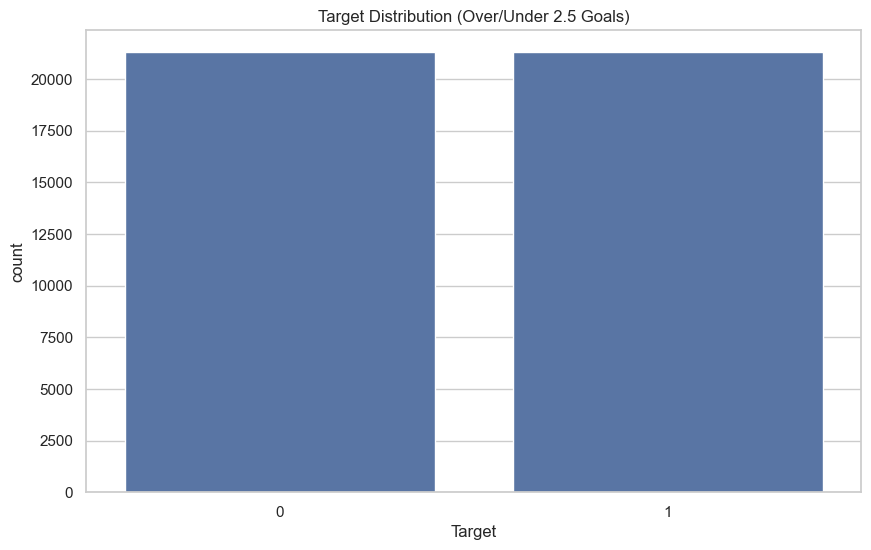

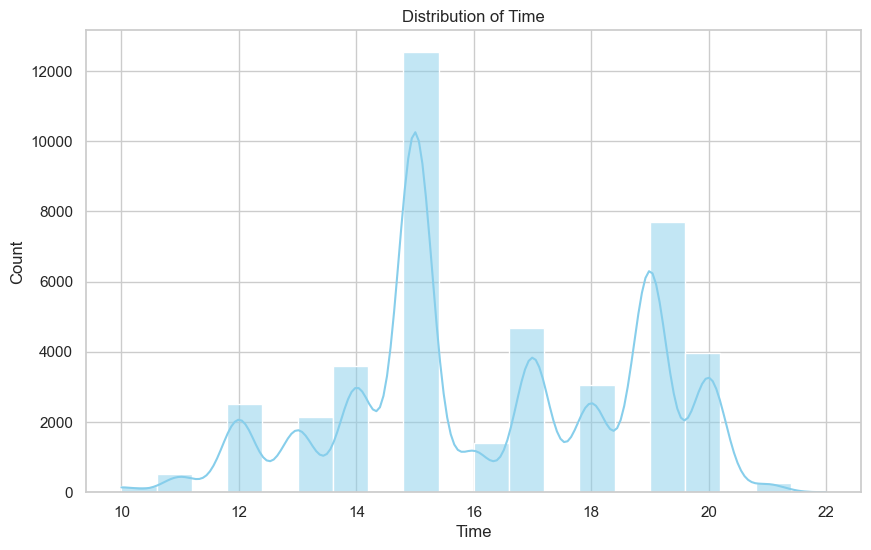

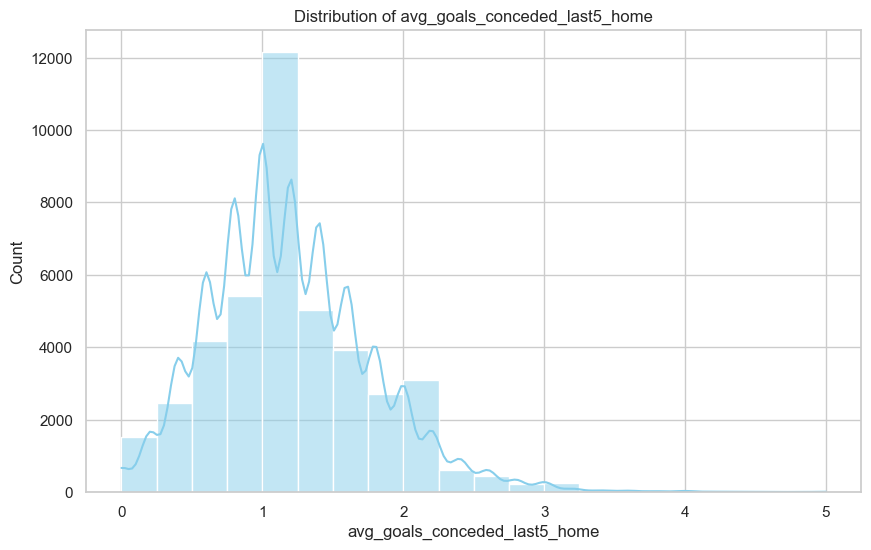

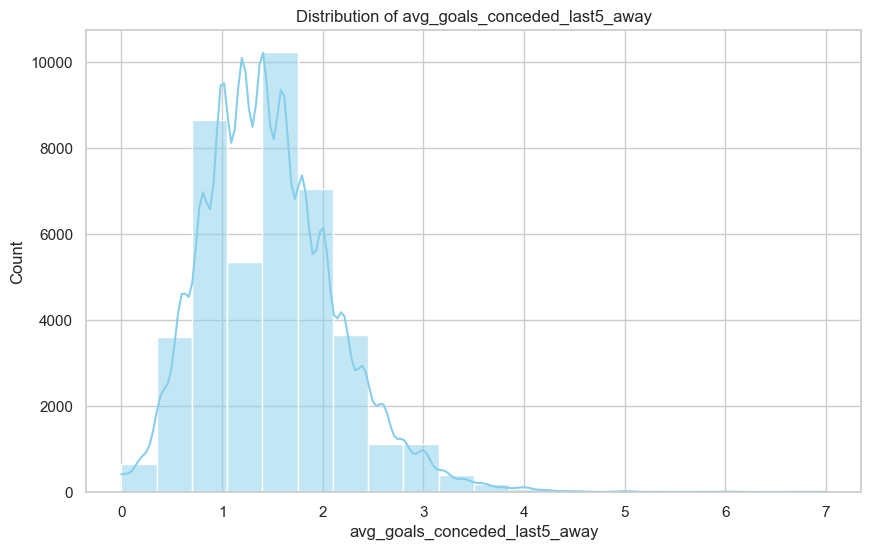

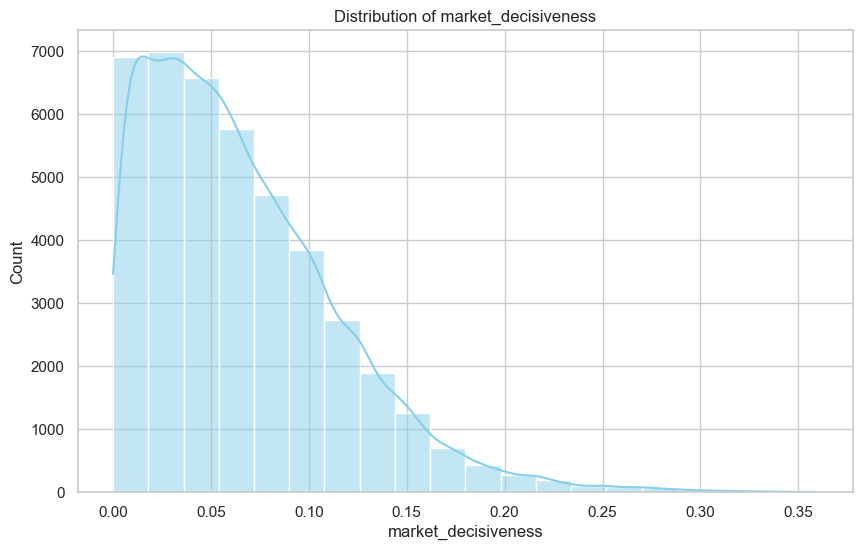

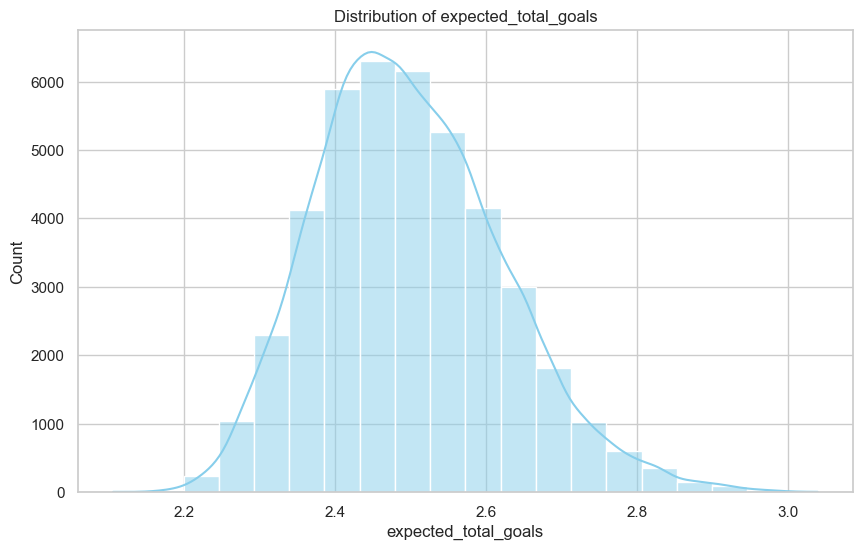

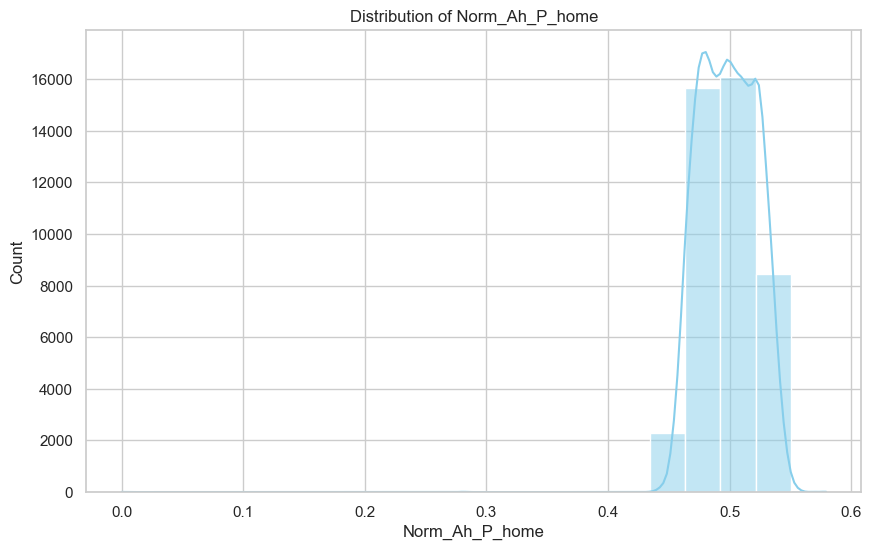

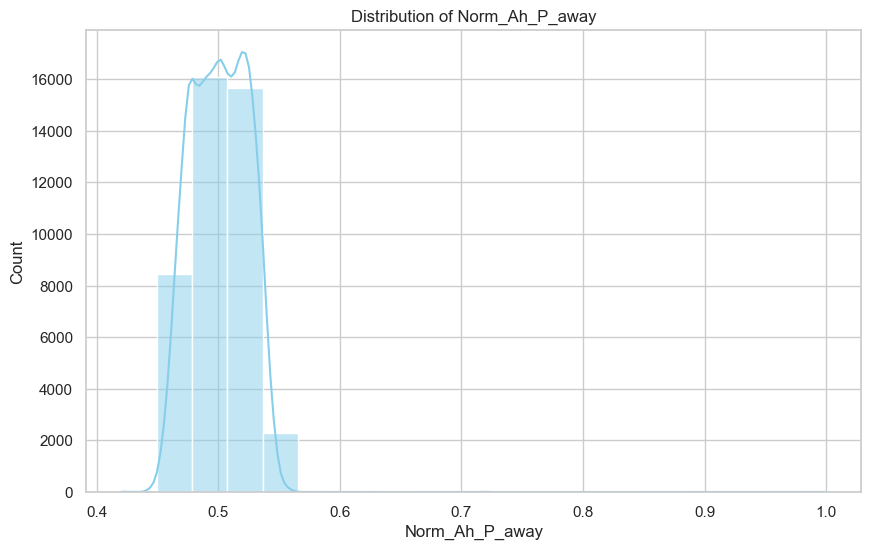

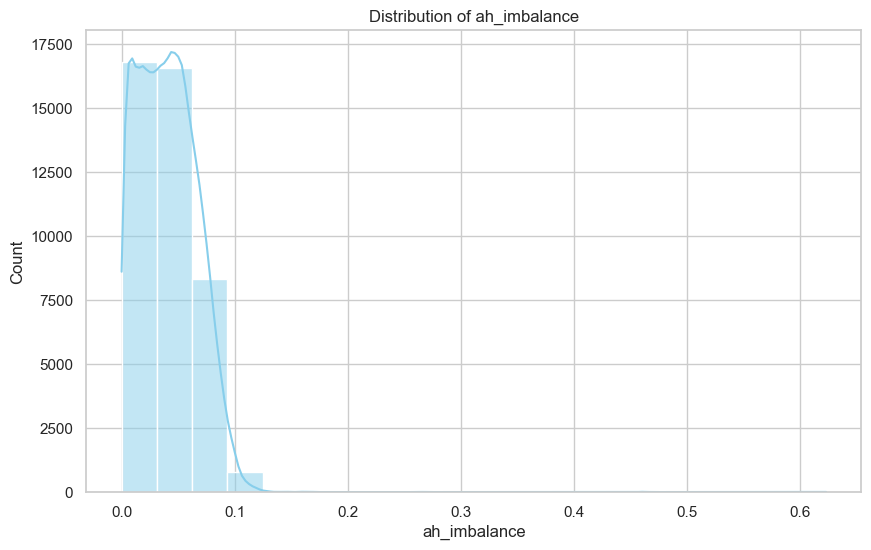

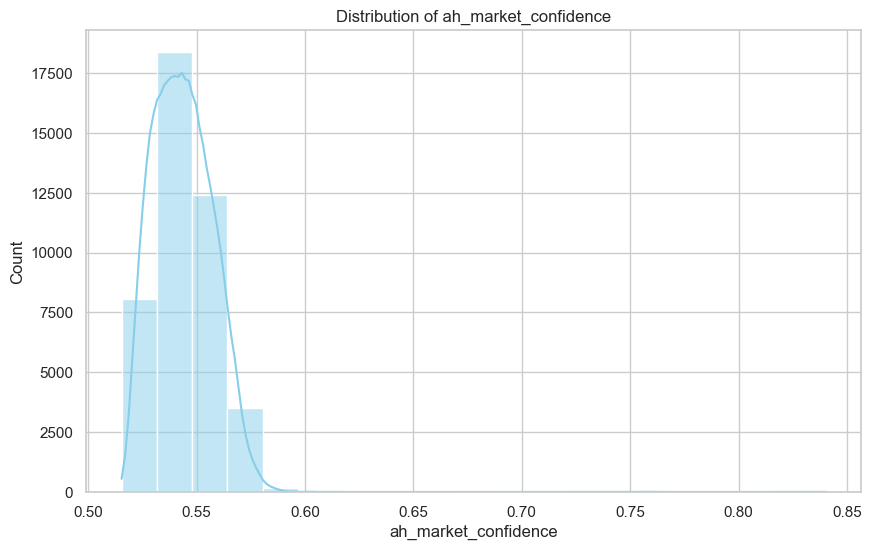

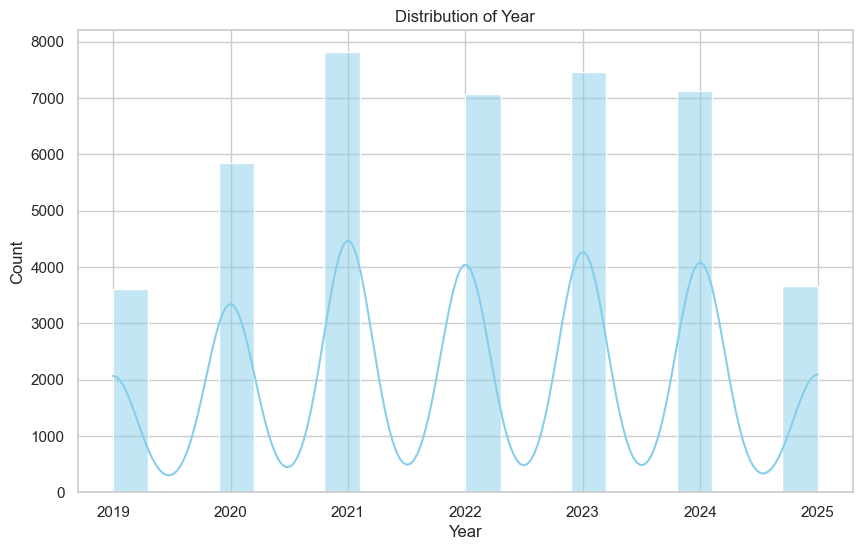

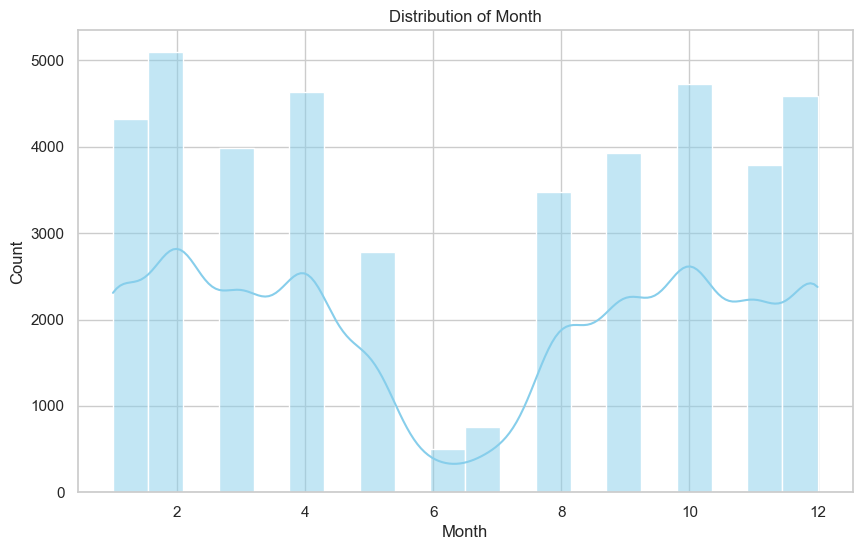

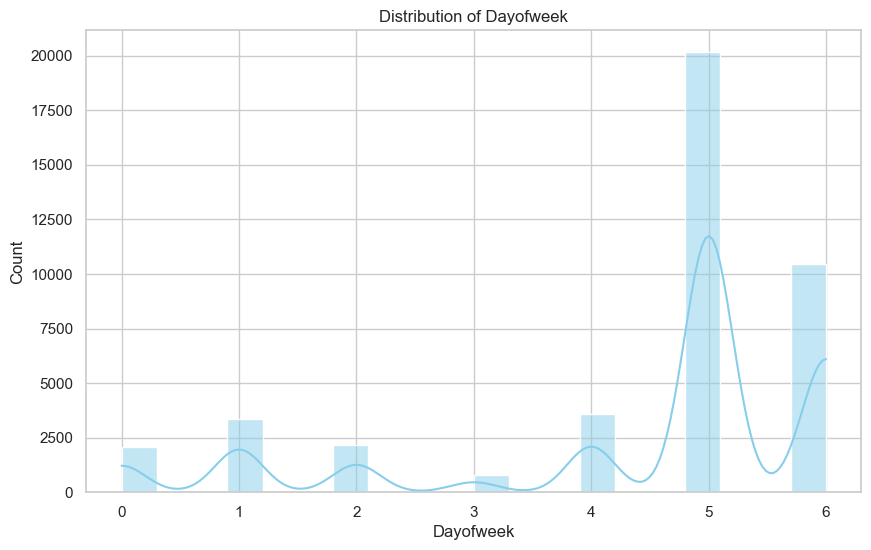

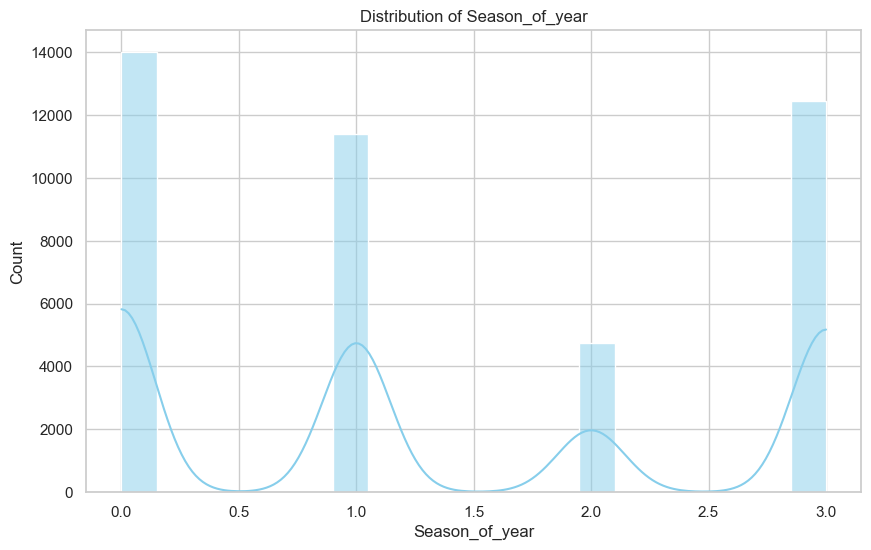

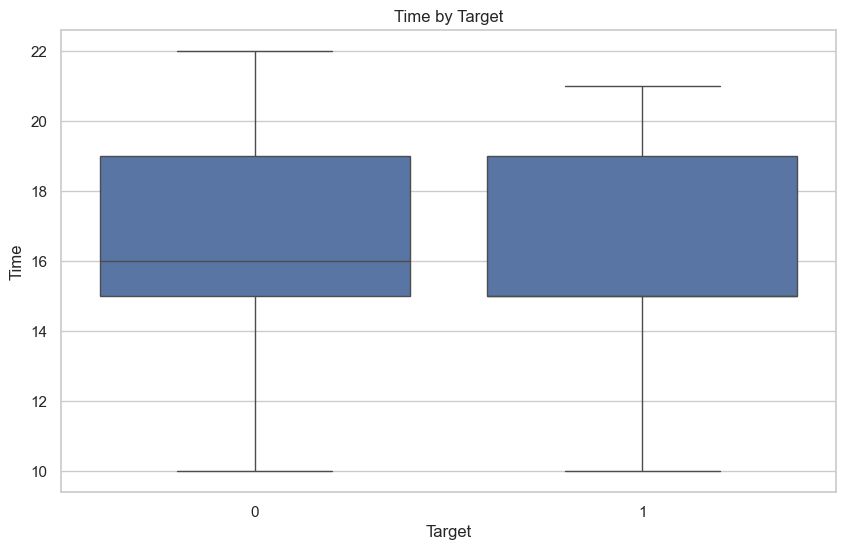

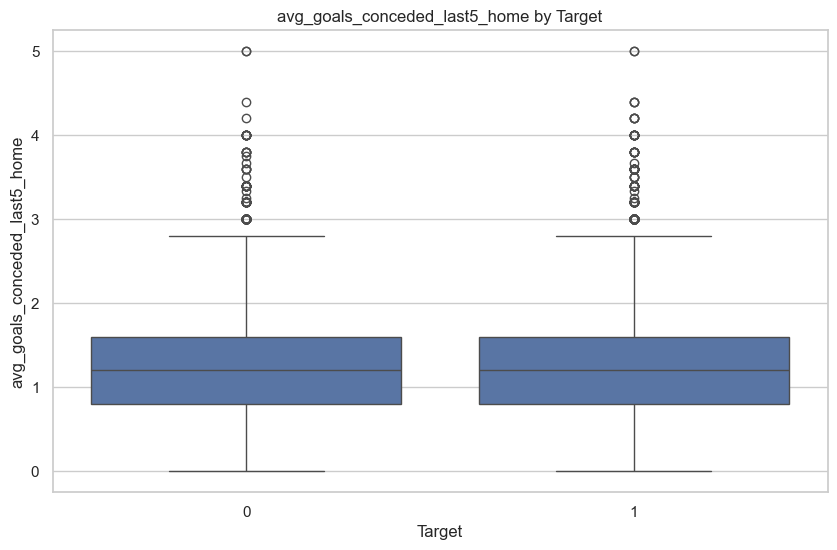

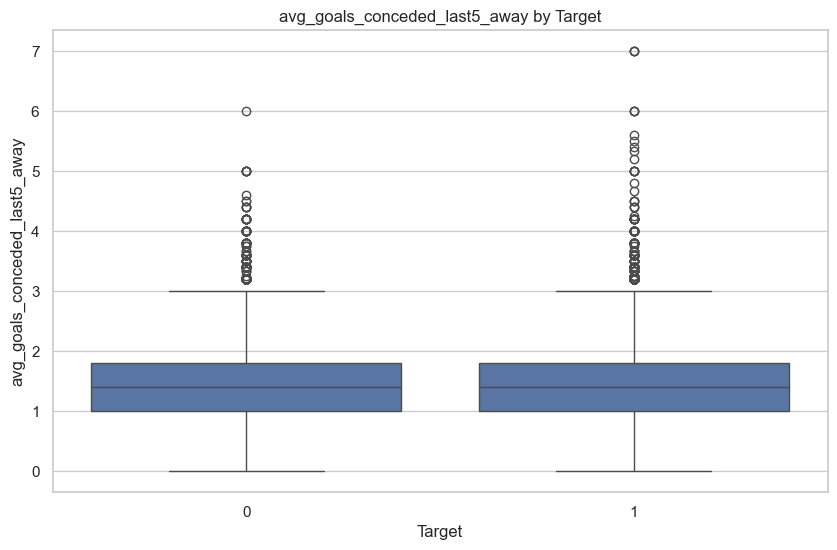

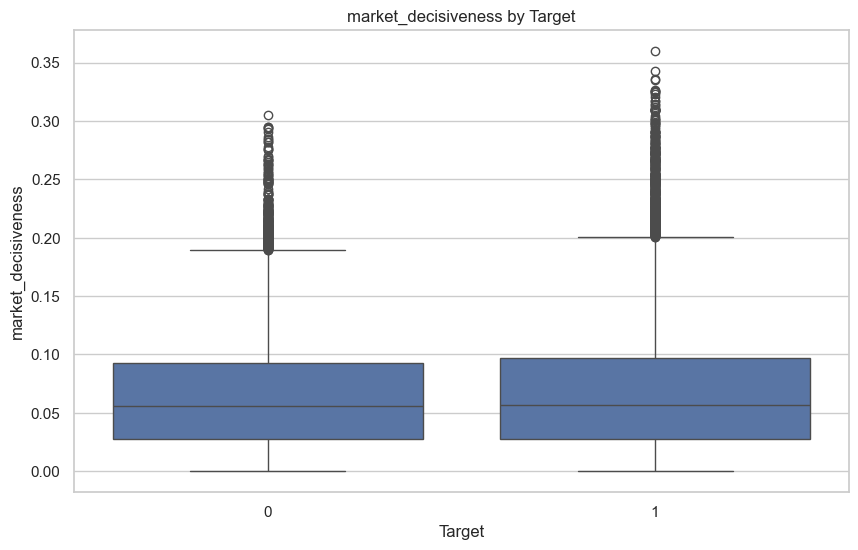

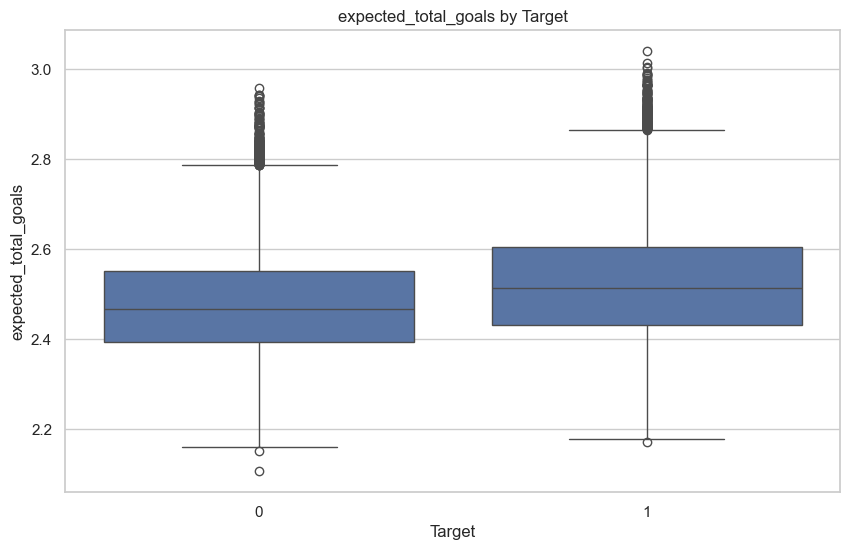

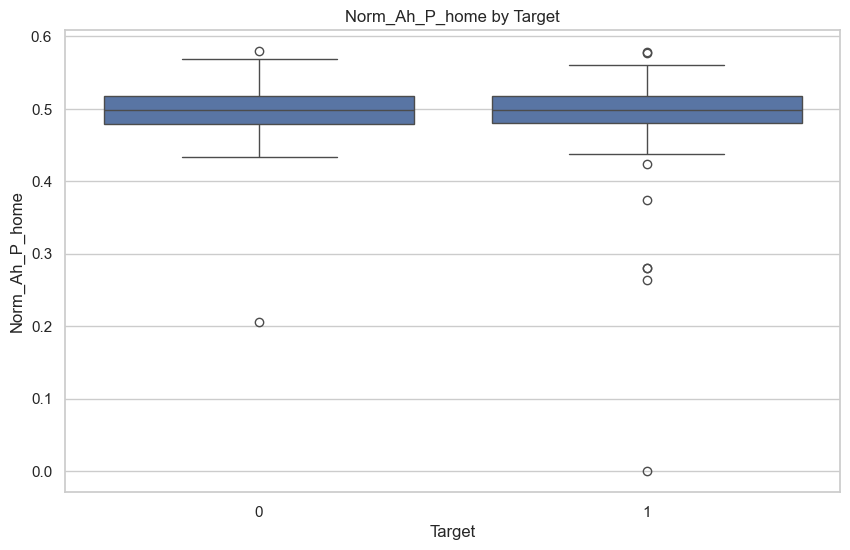

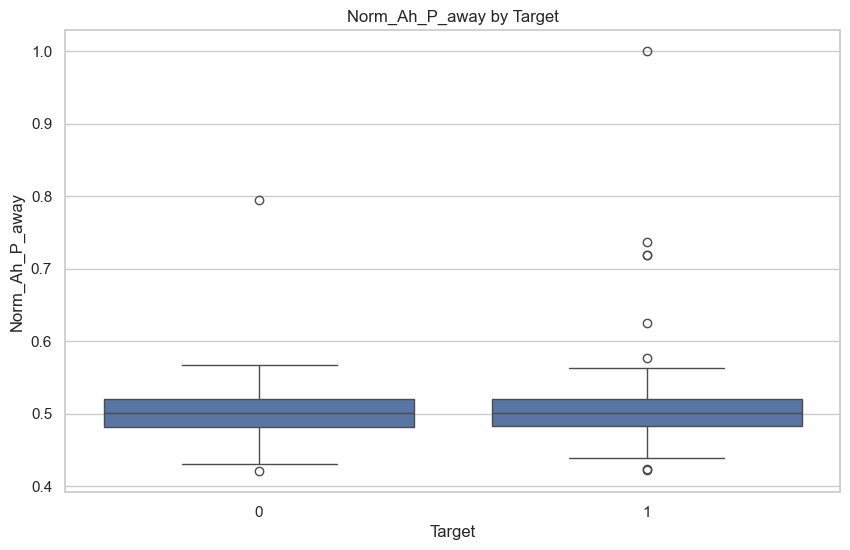

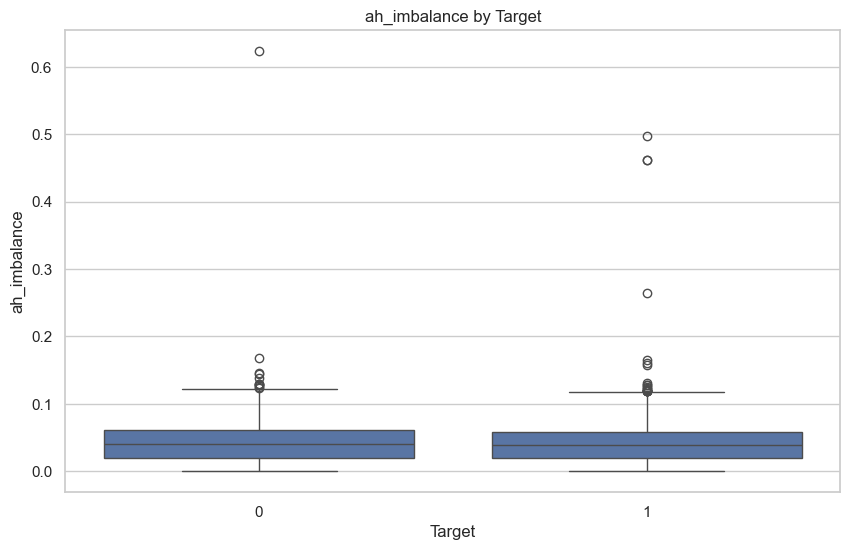

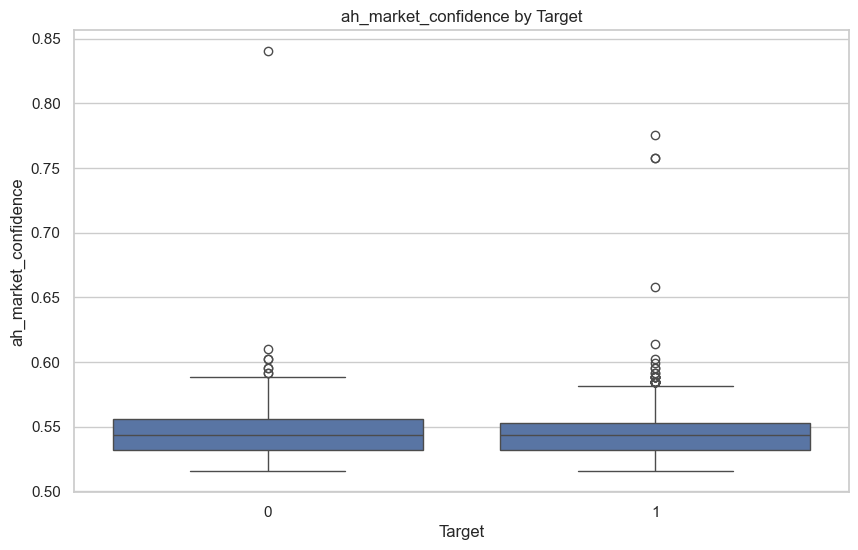

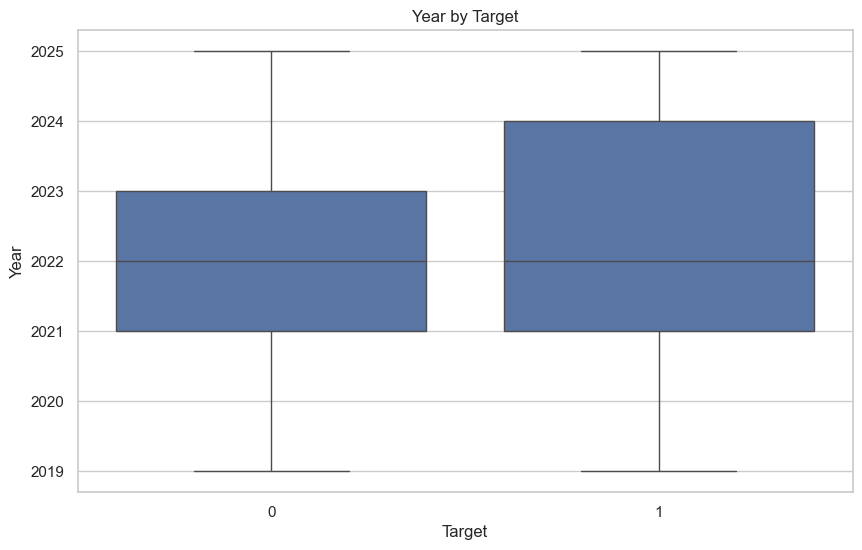

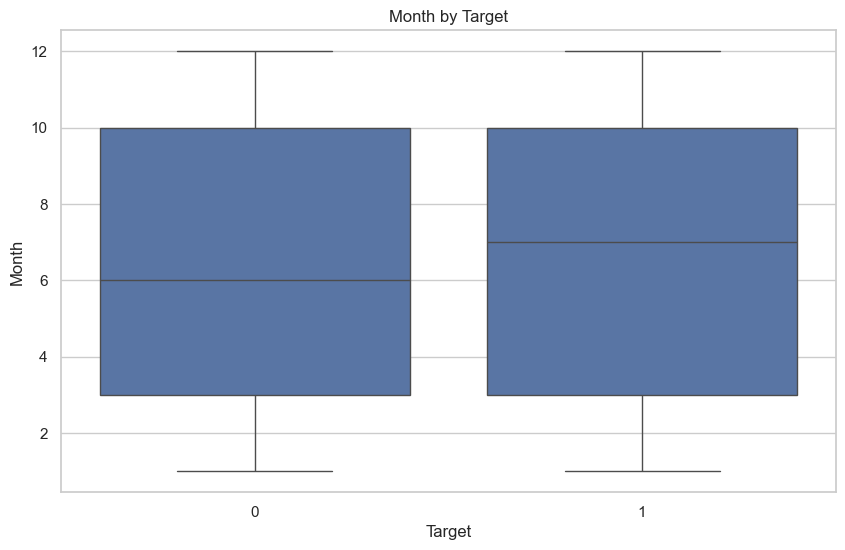

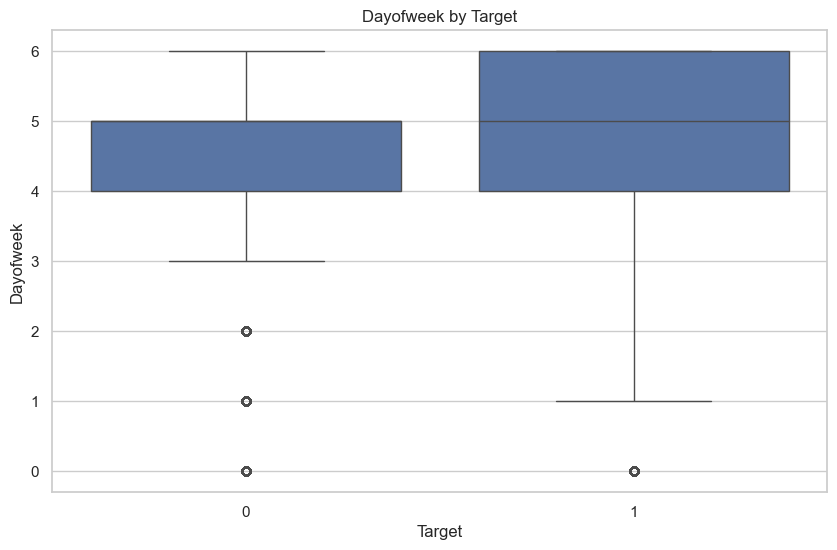

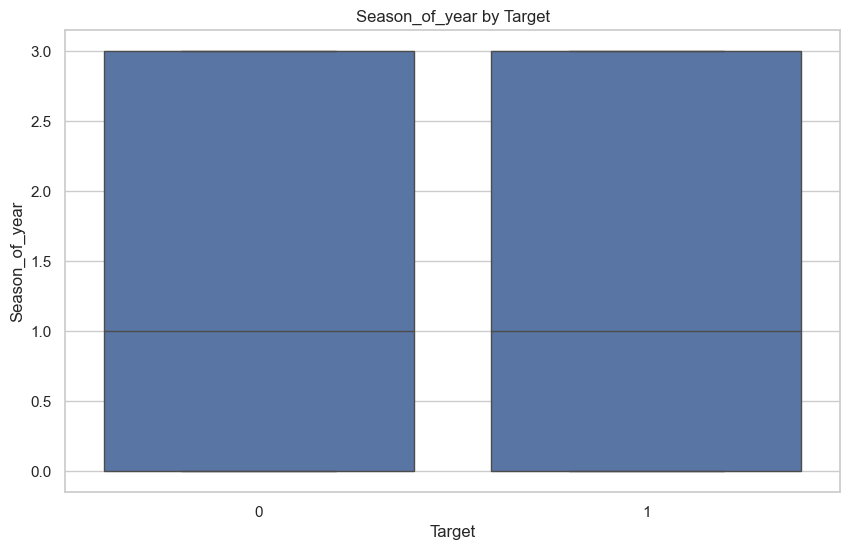

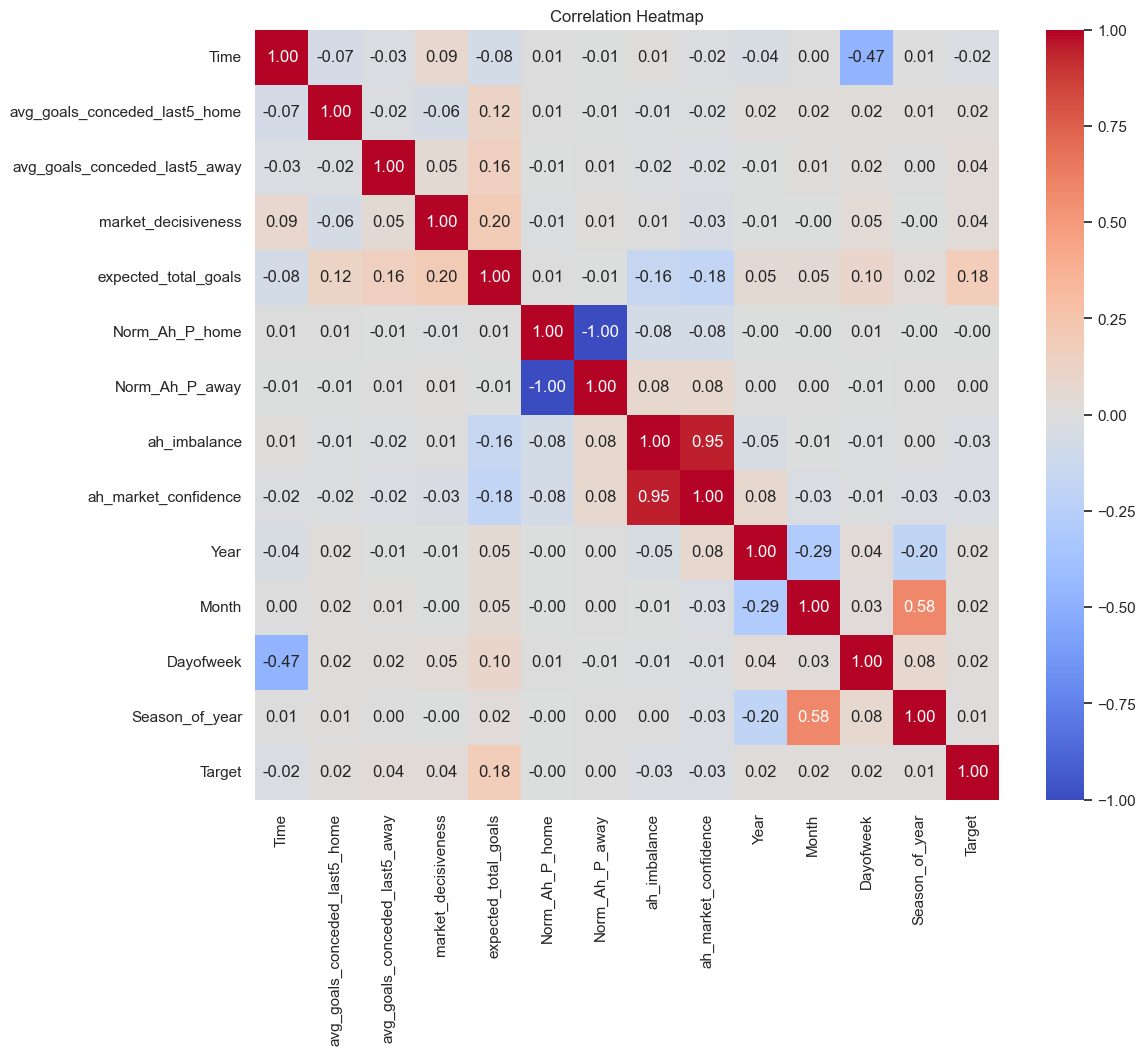

ValueError: Could not interpret value `Country` for `x`. An entry with this name does not appear in `data`.

<Figure size 1000x600 with 0 Axes>

In [286]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Set Seaborn style
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# ==========================
# 1️⃣ Target distribution
# ==========================
data_big_a1_encoded['Target'] = data_big_a1_encoded['Target'].astype(int)
sns.countplot(data=data_big_a1_encoded, x='Target')
plt.title('Target Distribution (Over/Under 2.5 Goals)')
plt.show()

# ==========================
# 2️⃣ Numerical features distributions
# ==========================
num_cols = [
    'Time', 'avg_goals_conceded_last5_home',
    'avg_goals_conceded_last5_away',
    'market_decisiveness', 'expected_total_goals',
    'Norm_Ah_P_home','Norm_Ah_P_away', 'ah_imbalance', 'ah_market_confidence',
    'Year', 'Month', 'Dayofweek','Season_of_year'
]

for col in num_cols:
    plt.figure()
    sns.histplot(data_big_a1_encoded[col], kde=True, bins=20, color='skyblue')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.show()

# ==========================
# 3️⃣ Boxplots by Target (handle NaNs)
# ==========================
for col in num_cols:
    plt.figure()
    sns.boxplot(data=data_big_a1_encoded, x='Target', y=col)
    plt.title(f'{col} by Target')
    plt.show()

# ==========================
# 4️⃣ Correlation heatmap (numeric only, drop NaNs)
# ==========================
corr = data_big_a1_encoded[num_cols + ['Target']].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.show()

# ==========================
# 5️⃣ Categorical features
# ==========================
cat_cols = ['Country', 'Division', 'Is_weekend']

for col in cat_cols:
    plt.figure()
    sns.countplot(data=data_big_a1_encoded, x=col)
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=45)
    plt.show()

# ==========================
# 6️⃣ Relationships between key features
# ==========================
plt.figure()
sns.scatterplot(
    data=data_big_a1_encoded, x='expected_total_goals', y='market_decisiveness',
    hue='Target', palette='coolwarm', alpha=0.6
)
plt.title('Expected Goals vs Market Decisiveness by Target')
plt.show()

plt.figure()
sns.scatterplot(
    data=data_big_a1_encoded, x='ah_imbalance', y='ah_market_confidence',
    hue='Target', palette='coolwarm', alpha=0.6
)
plt.title('AH Imbalance vs AH Market Confidence by Target')
plt.show()
